In [403]:
%matplotlib inline

In [404]:
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (15, 7)
sns.set_theme()

In [405]:
mvid = pd.read_csv('data/MVID_101001_171001.txt')
sber = pd.read_csv('data/SBER_101001_171001.txt')

In [406]:
df = pd.merge(sber, mvid, on='<DATE>')
df.head()

,<TICKER>_x,<PER>_x,<DATE>,<TIME>_x,<CLOSE>_x,<VOL>_x,<TICKER>_y,<PER>_y,<TIME>_y,<CLOSE>_y,<VOL>_y
0,SBER,D,20101001,0,89.09,332429890,MVID,D,0,194.38,19406
1,SBER,D,20101004,0,89.88,194032721,MVID,D,0,190.00,31039
2,SBER,D,20101005,0,91.97,198775753,MVID,D,0,187.00,17651
3,SBER,D,20101006,0,91.20,210406027,MVID,D,0,190.04,36482
4,SBER,D,20101007,0,90.40,145137617,MVID,D,0,199.85,204248


In [407]:
X = df['<CLOSE>_x']
y = df['<CLOSE>_y']

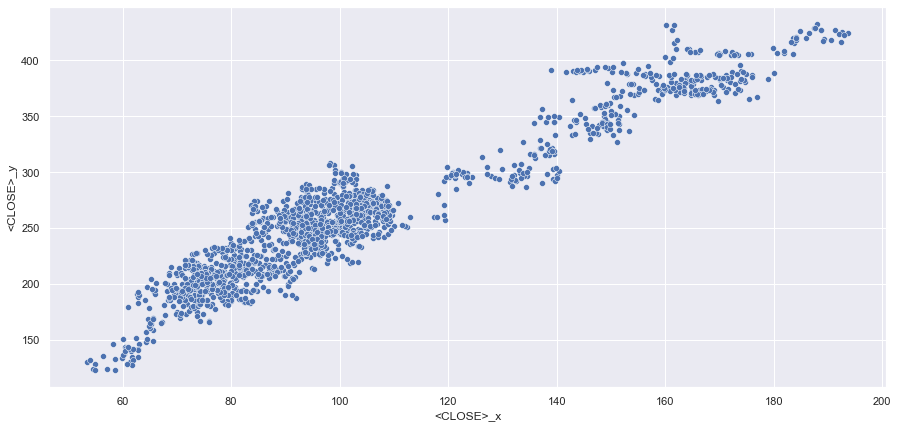

In [408]:
_ = sns.scatterplot(x=X, y=y)

In [409]:
# noinspection PyPep8Naming
class Hypothesis:
    b0: float
    b1: float

    def __init__(self):
        self._reset()

    def _reset(self):
        self.b0, self.b1 = 0, 0
        self._steps, self._train_metrics, self._test_metrics = [], [], []

    @property
    def steps(self) -> list[float]:
        return self._steps[:]

    @property
    def n_steps(self) -> int:
        return len(self._steps)

    @property
    def train_metrics(self) -> list[float]:
        return self._train_metrics[:]

    @property
    def test_metrics(self) -> list[float]:
        return self._test_metrics[:]

    def BGD(
            self,
            X: Any,
            y: Any,
            alpha: float = 0.000001,
            accuracy: float = 0.0001,
            max_steps: int = 5000,
            train_size: float = None,
    ) -> None:
        X_train, X_test, y_train, y_test = X, None, y, None
        if train_size:
            X_train, X_test, y_train, y_test = self.train_test_split(X, y, train_size=0.75)

        self._reset()
        metric, theta = 0, 1
        for i in range(max_steps):
            if theta < accuracy:
                return

            dy = self.predict(X_train) - y_train
            self.b0 -= alpha * np.mean(dy)
            self.b1 -= alpha * np.mean(dy * X_train)

            prev_metric = metric
            metric = self.mse(X_train, y_train)
            theta = np.abs(prev_metric - metric)

            self._steps.append(i)
            self._train_metrics.append(metric)

            if train_size and X_test is not None and y_test is not None:
                self._test_metrics.append(self.mse(X_test, y_test))

    def NAG(
            self,
            X: Any,
            y: Any,
            rho=0.9,
            alpha: float = 0.000001,
            accuracy: float = 0.0001,
            max_steps: int = 5000,
            train_size: float = None,
    ) -> None:
        """
        Nesterov Accelerated Gradient
        https://www.reg.ru/blog/stehnfordskij-kurs-lekciya-7-obuchenie-nejrosetej-chast-2/
        """
        X_train, X_test, y_train, y_test = X, None, y, None
        if train_size:
            X_train, X_test, y_train, y_test = self.train_test_split(X, y, train_size=0.75)

        self._reset()
        metric, theta = 0, 1

        v0, v1 = 0, 0
        for i in range(max_steps):
            if theta < accuracy:
                return

            dy = self.predict(X_train) - y_train

            prev_v0, v0, db0 = self._move(alpha * np.mean(dy), v0, rho)
            self.b0 += db0

            prev_v1, v1, db1 = self._move(alpha * np.mean(dy * X_train), v1, rho)
            self.b1 += db1

            prev_metric = metric
            metric = self.mse(X_train, y_train)
            theta = np.abs(prev_metric - metric)

            self._steps.append(i)
            self._train_metrics.append(metric)

            if train_size and X_test is not None and y_test is not None:
                self._test_metrics.append(self.mse(X_test, y_test))

    @classmethod
    def _move(cls, gradient: float, v0: float, rho: float) -> (float, float, float):
        prev_v0 = v0
        v0 = rho * v0 - gradient
        db = -prev_v0 * v0 + (1 + rho) * v0
        return prev_v0, v0, db

    def predict(self, X: Any) -> Any:
        return self.b0 + self.b1 * X

    def mse(self, X: Any, y: Any) -> float:
        return np.mean((self.predict(X) - y) ** 2)

    @classmethod
    def train_test_split(cls, X, y, test_size=None, train_size=None, random_state=None, shuffle=None):
        return train_test_split(
            X, y,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state,
            shuffle=shuffle
        )

In [410]:
hypothesis = Hypothesis()

hypothesis.BGD(X, y, train_size=0.75)
BGD_n_steps, BGD_mse = hypothesis.n_steps, hypothesis.mse(X, y)

hypothesis.NAG(X, y, train_size=0.75)
NAG_n_steps, NAG_mse = hypothesis.n_steps, hypothesis.mse(X, y)

hyp_pred = hypothesis.predict(X)

print(f'{BGD_n_steps=}, {BGD_mse=}')
print(f'{NAG_n_steps=}, {NAG_mse=}')

BGD_n_steps=737, BGD_mse=597.4393735052971
NAG_n_steps=133, NAG_mse=597.4547439825944


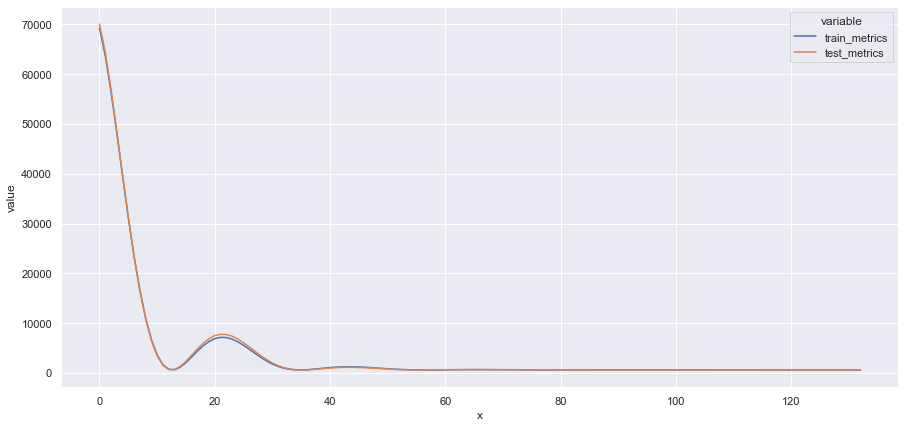

In [411]:
data = pd.DataFrame({
    'x': hypothesis.steps,
    'train_metrics': hypothesis.train_metrics,
    'test_metrics': hypothesis.test_metrics}
)
_ = sns.lineplot(data=data.melt('x'), x='x', y='value', hue='variable')

In [412]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
model = LinearRegression().fit(X_train.array.reshape(-1, 1), y_train.array.reshape(-1, 1))
sklearn_pred = model.predict(X.array.reshape(-1, 1))

r2_score(Hypothesis) = 0.8489920719778927
r2_score(LinearRegression) = 0.9110938043065037


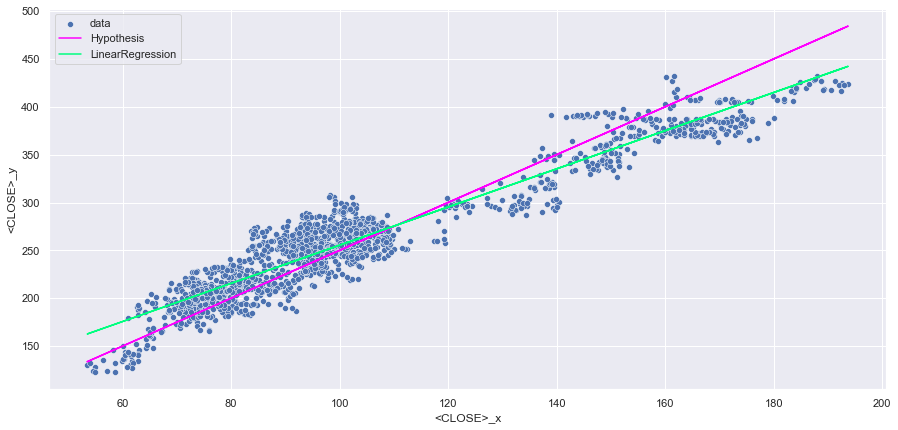

In [413]:
ax: Axes = sns.scatterplot(x=X, y=y)
ax.plot(X, hyp_pred, color='magenta')
ax.plot(X, sklearn_pred, color='springgreen')
ax.legend(['data', 'Hypothesis', 'LinearRegression'])
print(f'r2_score(Hypothesis) = {r2_score(y, hyp_pred)}')
print(f'r2_score(LinearRegression) = {r2_score(y, sklearn_pred)}')